### Initial Data Look


In [108]:
import os
import pandas as pd
from scipy.stats import ttest_ind, mannwhitneyu
import random
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt


In [109]:
all_data = []
for file in tqdm(os.listdir('../twitter-data/test')):
    data = pd.read_json(f'../twitter-data/test/{file}')
    all_data.append(data)
df = pd.concat(all_data)
print(len(df))
df = df.drop_duplicates('statusHref')
print(len(df))

100%|██████████| 125/125 [00:00<00:00, 276.89it/s]

5634
5193


In [110]:
df

,datetime,authorNickname,likes,reposts,comments,views,innerText,statusHref
0,2025-01-06 19:44:54+00:00,SchwurbelWatch,27.0,2.0,2.0,643.0,Fun-Fact zu Christoph Berndt von der #AfD:\n\n...,/schwurbelwatch/status/1876354272608051430
1,2025-01-06 16:10:03+00:00,Heute im Bundestag,1.0,1.0,0.0,495.0,AfD-Fraktion: Bildungsnachteile von Jungen abb...,/hib_Nachrichten/status/1876300203940081786
2,2025-01-06 09:54:31+00:00,gerecht,2.0,2.0,0.0,405.0,wußte ich´s doch. die äfft Frau Dr. Alice Weid...,/gerecht321/status/1876205700629860599
3,2025-01-06 13:55:01+00:00,AfD-Fraktion im Landtag RLP,23.0,7.0,0.0,167.0,Wir wünschen Ihnen einen schönen #Dreikönigsta...,/AfDFraktionRLP/status/1876266222674694252
4,2025-01-06 15:11:54+00:00,silvia Maidorn,0.0,0.0,0.0,6.0,Fr. #AliceWeidel hat die Corona-Hysterie orden...,/SilviaMaidorn/status/1876285572593209801
...,...,...,...,...,...,...,...,...
48,2025-01-07 13:56:14+00:00,Luc Cuyx | | #SaysNoToRacism,4.0,1.0,2.0,78.0,Dat #AfD-covoorzitter #AliceWeidel er ongeloof...,/LucCuyx/status/1876628915441013253
49,2025-01-07 06:20:36+00:00,Victoria J. Ⓥ Team Habeck!,18.0,7.0,0.0,1700.0,"Im Übrigen bin ich der Meinung, dass die #AfD ...",/Toriabethx/status/1876514252187680833
50,2025-01-07 13:50:30+00:00,Lu ohne CiA,4.0,0.0,0.0,25.0,#AfD darf bei uns jede 3. Laterne plakatieren....,/Loukasmus/status/1876627474886316354
51,2025-01-07 09:34:22+00:00,Green Pixel,8.0,2.0,2.0,83.0,Oh man. #Soeder. Ich verliere langsam jeden Re...,/SunCatVsMoonDog/status/1876563016684384284


In [112]:
def compare_likes(df, date_column, likes_column, cutoff_date):
    # Ensure datetime column and cutoff_date are timezone-aware
    df[date_column] = pd.to_datetime(df[date_column]).dt.tz_convert('UTC')
    cutoff_date = pd.Timestamp(cutoff_date, tz='UTC')

    # Split data into two groups
    before = df.loc[df[date_column] < cutoff_date, likes_column]
    after = df.loc[df[date_column] >= cutoff_date, likes_column]
    before = before.dropna()
    after = after.dropna()
    print(len(before), len(after))
    # Perform statistical tests
    t_stat, t_pval = ttest_ind(before, after, equal_var=False)
    u_stat, u_pval = mannwhitneyu(before, after)

    # Results
    print(f"Two-sample t-test p-value: {t_pval:.4f}")
    print(f"Mann-Whitney U test p-value: {u_pval:.4f}")

    if t_pval < 0.05:
        print("The difference in likes before and after the cutoff date is statistically significant (t-test).")
    else:
        print("No statistically significant difference in likes before and after the cutoff date (t-test).")

    if u_pval < 0.05:
        print("The difference in likes before and after the cutoff date is statistically significant (Mann-Whitney U test).")
    else:
        print("No statistically significant difference in likes before and after the cutoff date (Mann-Whitney U test).")


cutoff_date = '2024-12-20'
compare_likes(df, 'datetime', 'views', cutoff_date)


2419 2766
Two-sample t-test p-value: 0.1018
Mann-Whitney U test p-value: 0.0881
No statistically significant difference in likes before and after the cutoff date (t-test).
No statistically significant difference in likes before and after the cutoff date (Mann-Whitney U test).


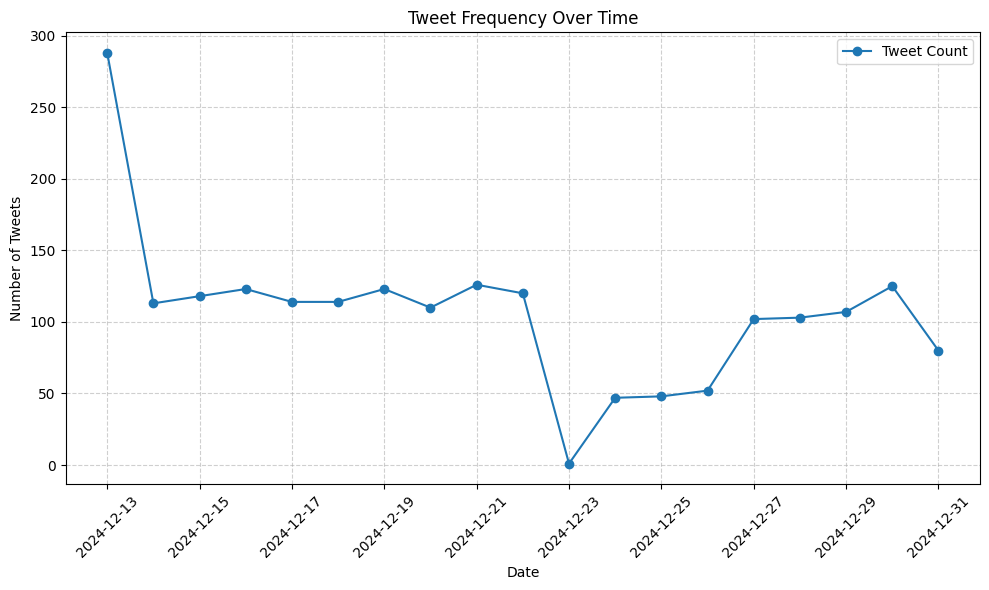

In [83]:
import pandas as pd
import matplotlib.pyplot as plt

df['datetime'] = pd.to_datetime(df['datetime'])  # Ensure datetime is in the correct format

# Group by date to count tweets per day
df['date'] = df['datetime'].dt.date  # Extract date (ignoring time)
tweet_counts = df.groupby('date').size().reset_index(name='tweet_count')

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(tweet_counts['date'], tweet_counts['tweet_count'], marker='o', linestyle='-', label='Tweet Count')
plt.title('Tweet Frequency Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


In [73]:
df['datetime'] = pd.to_datetime(df['datetime']).dt.tz_localize(None)  # Make datetime timezone-naive

# Define cutoff date (timezone-naive)
cutoff_date = pd.Timestamp('2024-12-20T00:00:00')

# Split data into two groups: before and after the cutoff date
before_cutoff = df[df['datetime'] < cutoff_date]['likes']
after_cutoff = df[df['datetime'] >= cutoff_date]['likes']

In [75]:
before_cutoff.mean(), after_cutoff.mean()

(np.float64(239.18883610451306), np.float64(353.4650512581547))

In [93]:
df

,datetime,authorNickname,likes,reposts,comments,views,innerText,statusHref,period
0,2024-12-27 17:27:01,"domingo4ever , Habeck4kanzler",15.0,10.0,8.0,509.0,Ich bin #Demokrat*in. Deshalb lehne ich die #A...,/domingo4ever1/status/1872695694144016427,After
1,2024-12-27 13:09:09,Ella ,926.0,273.0,49.0,30000.0,"Wer wissen will, mit welchen Neonazis sich Bun...",/Ella_von_T/status/1872630800858136999,After
2,2024-12-27 09:37:43,Rom,16.0,5.0,4.0,9600.0,Sondage des futures élections allemandes ! \n\...,/21romrom/status/1872577593062600888,After
3,2024-12-27 17:05:19,Zeitgeschehen,10000.0,1300.0,3700.0,190000.0,"Wenn das kein Ansporn ist, die #AfD zu wählen...",/Zeitgeschehen_/status/1872690236402397247,After
4,2024-12-27 11:21:17,Miguel Klauß,457.0,170.0,11.0,3100.0,Niemals vergessen. Die Einwanderungspolitik vo...,/Miguel_Klauss/status/1872603657705075128,After
...,...,...,...,...,...,...,...,...,...
75,2024-12-31 19:04:28,Nicolesmith,53.0,13.0,6.0,2300.0,#CDU #AfD wie nutzt ihr die #Bagger Fahrt denn...,/Nicoles44180590/status/1874169772113616948,After
76,2024-12-31 08:46:42,Senfda Tzu,7.0,0.0,1.0,454.0,Nachrichten zum Jahreswechsel: 2025 Altparteie...,/SenfdaTzu/status/1874014303487242300,After
77,2024-12-31 22:16:48,"Götz Frömming, MdB",365.0,52.0,28.0,3400.0,"Kurz vor dem Jahreswechsel hat die AfD mit 20,...",/GtzFrmming/status/1874218174557876386,After
78,2024-12-31 23:02:31,Günter Geuking,3.0,0.0,0.0,331.0,Frohes neues Jahr . #Sylvester ...,/GGeuking/status/1874229678145249327,After


/var/folders/jj/_szc94p56q91q_7c209d1d9w0000gn/T/ipykernel_72928/533240606.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='period', y='likes', data=df, palette='Set2', showfliers=True)


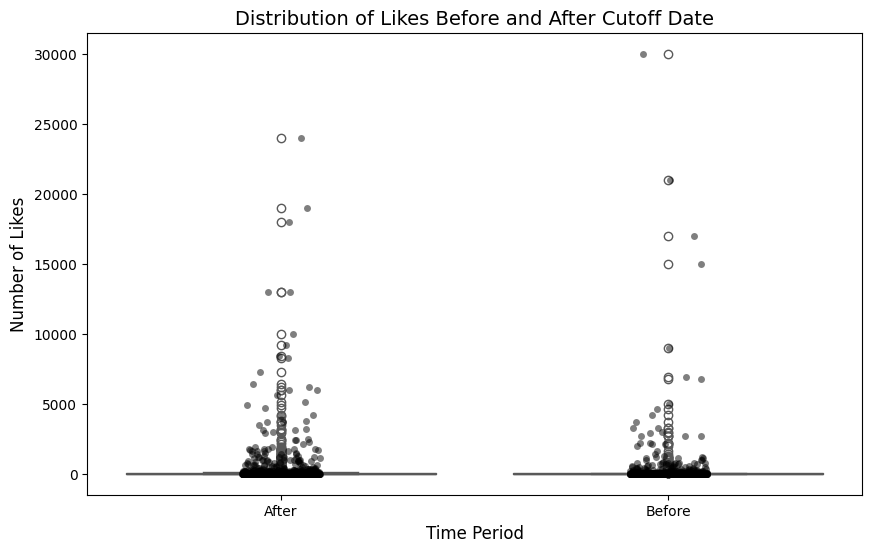

In [101]:
df['datetime'] = pd.to_datetime(df['datetime']).dt.tz_localize(None)
cutoff_date = pd.Timestamp('2024-12-20') 

# Combine data into one DataFrame
df['period'] = df['datetime'].apply(lambda x: 'Before' if x < cutoff_date else 'After')

df['likes'] = pd.to_numeric(df['likes'], errors='coerce').fillna(0)

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='period', y='likes', data=df, palette='Set2', showfliers=True)
sns.stripplot(x='period', y='likes', data=df, color='black', alpha=0.5, jitter=True)
plt.title('Distribution of Likes Before and After Cutoff Date', fontsize=14)
plt.xlabel('Time Period', fontsize=12)
plt.ylabel('Number of Likes', fontsize=12)
plt.show()


/var/folders/jj/_szc94p56q91q_7c209d1d9w0000gn/T/ipykernel_72928/101673555.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='period', y='likes', data=df, palette='Set3')


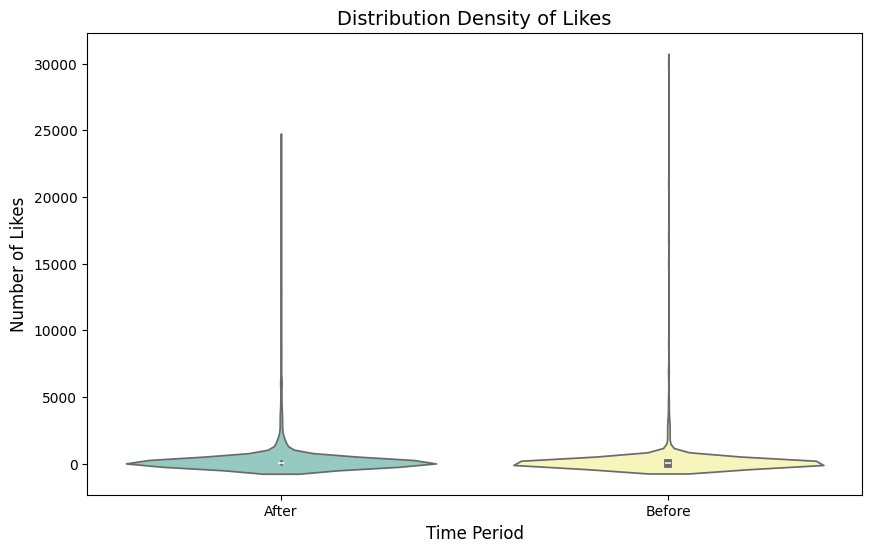

In [102]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='period', y='likes', data=df, palette='Set3')
plt.title('Distribution Density of Likes', fontsize=14)
plt.xlabel('Time Period', fontsize=12)
plt.ylabel('Number of Likes', fontsize=12)
plt.show()


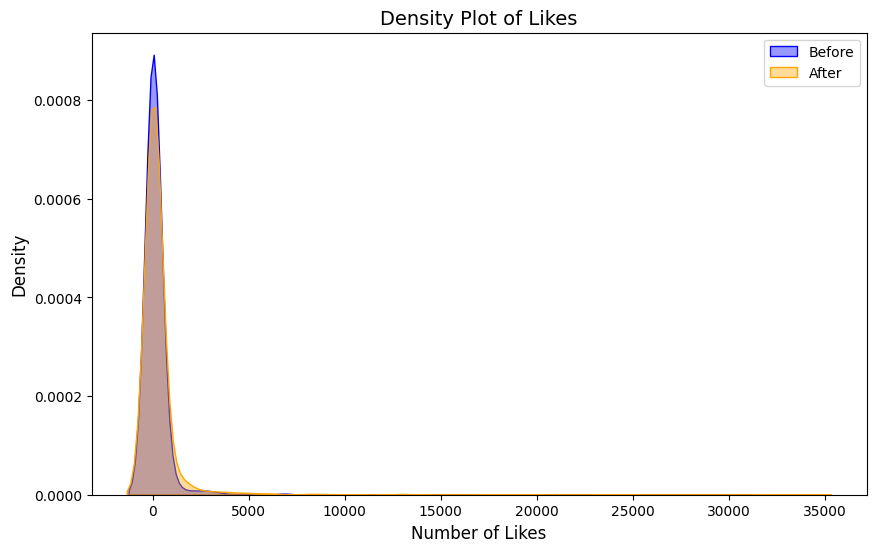

In [103]:
plt.figure(figsize=(10, 6))
sns.kdeplot(before_cutoff, label='Before', fill=True, color='blue', alpha=0.4)
sns.kdeplot(after_cutoff, label='After', fill=True, color='orange', alpha=0.4)
plt.title('Density Plot of Likes', fontsize=14)
plt.xlabel('Number of Likes', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.show()


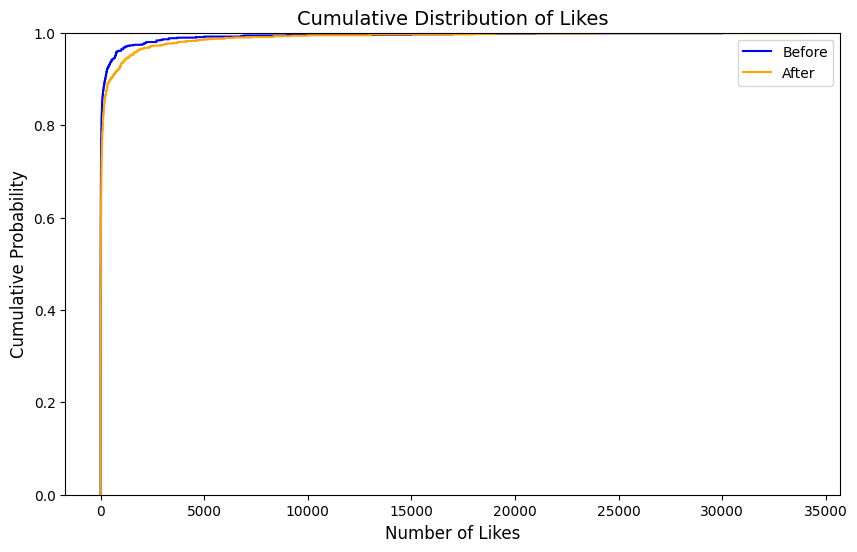

In [104]:
plt.figure(figsize=(10, 6))
sns.ecdfplot(before_cutoff, label='Before', color='blue')
sns.ecdfplot(after_cutoff, label='After', color='orange')
plt.title('Cumulative Distribution of Likes', fontsize=14)
plt.xlabel('Number of Likes', fontsize=12)
plt.ylabel('Cumulative Probability', fontsize=12)
plt.legend()
plt.show()
